In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
litecoin_train=pd.read_csv('Litecoin_train.csv')
monero_train=pd.read_csv('Monero_train.csv')
litecoin_test=pd.read_csv('Litecoin_test.csv')
monero_test=pd.read_csv('Monero_test.csv')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
litecoin_train.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Feb 22, 2020",74.818,73.288,76.642,72.422,11.56M,2.08%
1,"Feb 21, 2020",73.291,69.455,75.161,68.633,12.13M,5.52%
2,"Feb 20, 2020",69.455,70.782,72.339,66.495,12.45M,-1.87%
3,"Feb 19, 2020",70.782,77.173,79.041,68.264,12.10M,-8.28%
4,"Feb 18, 2020",77.173,73.357,78.911,70.217,10.64M,5.22%


In [ ]:
litecoin_train=litecoin_train.iloc[::-1].reset_index(drop=True)

In [ ]:
litecoin_train.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 24, 2016",3.84,3.95,3.96,3.61,21.86K,-2.78%
1,"Aug 25, 2016",3.81,3.84,3.88,3.75,21.87K,-0.78%
2,"Aug 26, 2016",3.81,3.81,3.90,3.77,14.35K,0.00%
3,"Aug 27, 2016",3.78,3.81,3.85,3.62,4.91K,-0.79%
4,"Aug 28, 2016",3.72,3.78,3.78,3.62,8.19K,-1.59%


In [ ]:
litecoin_test=litecoin_test.iloc[::-1].reset_index(drop=True)
monero_train=monero_train.iloc[::-1].reset_index(drop=True)
monero_test=monero_test.iloc[::-1].reset_index(drop=True)

#Data Preprocessing

In [ ]:
def preprocess(monero):
  #find closing price
  monero['change']=monero['Change %'].str.replace('%','')
  monero=monero.astype({'change':'float'})
  monero['Close']=monero['Open']*(1+monero['change']/100)
  #replace - with 0 and change volume to int
  monero['Vol.']=monero['Vol.'].replace('-',0)
  monero['Vol.']= (monero['Vol.'].replace(r'[KM]+$', '', regex=True).astype(float) * \
          monero['Vol.'].str.extract(r'[\d\.]+([KM]+)', expand=False)
            .fillna(1)
            .replace(['K','M'], [10**3, 10**6]).astype(int))
  monero['Vol.']=monero['Vol.'].replace('-',0)
  monero['Vol.']=monero['Vol.'].astype(int)
  #just save feature columns
  cols = ['Price','Open','High','Low','Vol.','Close']
  monero=monero[cols]
  #normalize
  mmscaler = MinMaxScaler(feature_range=(0,1))
  monero = pd.DataFrame(mmscaler.fit_transform(monero), columns=monero.columns)
  return monero,mmscaler

In [ ]:
litecoin_train=preprocess(litecoin_train)[0]
monero_train=preprocess(monero_train)[0]
litecoin_test,litecoin_scaler=preprocess(litecoin_test)
monero_test,monero_scaler=preprocess(monero_test)

#create train dataset

In [ ]:
import numpy as np
def create_nextday_dataset(data,lag=30):
  k=len(data)-lag
  x=[]
  y=[]
  for i in range(k):
    x.append(data[i:i+lag])
    y.append(data.iloc[i+lag])
  x=np.array(x)
  y=np.array(y)
  return x,y

In [ ]:
from sklearn.model_selection import train_test_split
monero_x,monero_y=create_nextday_dataset(monero_train)
litecoin_x,litecoin_y=create_nextday_dataset(litecoin_train)
# x_train_monero, x_val_monero, y_train_monero,y_val_monero = train_test_split(monero_x,monero_y, test_size=0.1)
# x_train_litecoin, x_val_litecoin, y_train_litecoin,y_val_litecoin = train_test_split(litecoin_x,litecoin_y, test_size=0.1)


#Structure

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM,GRU,Concatenate,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.activations import relu
#from tensorflow.keras.metrics import MeanAbsoluteError,MeanSquaredError,MeanAbsolutePercentageError,RootMeanSquaredError

In [ ]:
import keras.backend as K
def MSE_price(y_true, y_pred):
    loss = K.mean(K.square(y_true[:, 0] - y_pred[:, 0]))
    return loss
def RMSE_price(y_true, y_pred):
    loss = K.sqrt(K.mean(K.square(y_true[:, 0] - y_pred[:, 0])))
    return loss
def MAE_price(y_true, y_pred):
    loss = K.mean(K.abs(y_true[:, 0] - y_pred[:, 0]))
    return loss
def MAPE_price(y_true, y_pred):
    loss = 100*K.mean(K.abs((y_true[:, 0] - y_pred[:, 0]) / K.clip(K.abs(y_true[:, 0]), K.epsilon(), None)))
    return loss
def scheduler(epoch, lr):
  if epoch==50:
    return 0.1*lr
  else:
    return lr


In [ ]:
  LSTM_Part=Sequential()
  LSTM_Part.add(LSTM(30,return_sequences=True,input_shape=(30,6)))
  LSTM_Part.add(Dropout(0.3))
  LSTM_Part.add(LSTM(50))
  LSTM_Part.add(Dense(50,activation=relu))
  GRU_part=Sequential()
  GRU_part.add(GRU(30))
  GRU_part.add(Dropout(0.3))
  GRU_part.add(Dense(30,activation=relu))
  x=Input((30,6))
  y=Concatenate()([LSTM_Part(x),GRU_part(x)])
  z=Dense(6,activation=relu)(y)
  full_hybrid=tf.keras.Model(inputs=x,outputs=z)
  full_hybrid.compile(optimizer=Adam(learning_rate=0.001),loss=MSE_price,metrics=[MAE_price,MAPE_price,RMSE_price])

#Monero proposed model train and results

In [ ]:
#earlystopping= EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
lr_schedule=tf.keras.callbacks.LearningRateScheduler(scheduler)                                                                                            
monero_cp = ModelCheckpoint('drive/MyDrive/monero.hdf5', monitor='MAPE_price', mode='min',save_best_only=True)
monero_hist=full_hybrid.fit(monero_x,monero_y,batch_size=32,epochs=100,callbacks=[monero_cp,lr_schedule])
                            #,validation_data=(x_val_monero,y_val_monero))

Epoch 1/100
57/57 [==============================] - 9s 30ms/step - loss: 0.0184 - MAE_price: 0.0763 - MAPE_price: 990.6318 - RMSE_price: 0.1214 - lr: 1.0000e-04
Epoch 2/100
57/57 [==============================] - 5s 87ms/step - loss: 0.0037 - MAE_price: 0.0390 - MAPE_price: 690.4861 - RMSE_price: 0.0584 - lr: 1.0000e-04
Epoch 3/100
57/57 [==============================] - 1s 15ms/step - loss: 0.0028 - MAE_price: 0.0266 - MAPE_price: 45.2640 - RMSE_price: 0.0499 - lr: 1.0000e-04
Epoch 4/100
57/57 [==============================] - 2s 41ms/step - loss: 0.0023 - MAE_price: 0.0242 - MAPE_price: 42.7827 - RMSE_price: 0.0456 - lr: 1.0000e-04
Epoch 5/100
57/57 [==============================] - 2s 31ms/step - loss: 0.0021 - MAE_price: 0.0228 - MAPE_price: 45.6580 - RMSE_price: 0.0431 - lr: 1.0000e-04
Epoch 6/100
57/57 [==============================] - 1s 9ms/step - loss: 0.0020 - MAE_price: 0.0216 - MAPE_price: 52.6384 - RMSE_price: 0.0421 - lr: 1.0000e-04
Epoch 7/100
57/57 [==============

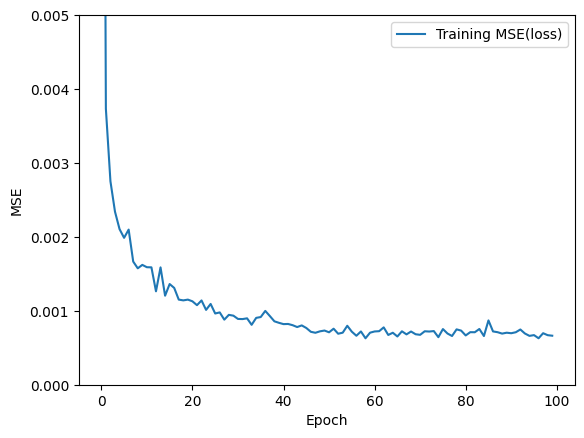

In [ ]:
import matplotlib.pyplot as plt
MSE = monero_hist.history['loss']
MAE = monero_hist.history['MAE_price']
# Plot MSE
plt.plot(MSE, label='Training MSE(loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim((0,0.005))
plt.legend()
plt.show()

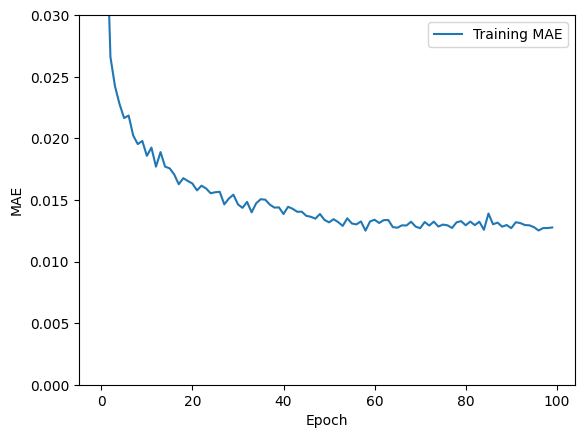

In [ ]:
# Plot MAE
plt.plot(MAE, label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.ylim((0,0.03))
plt.show()

In [ ]:
def predict_next_days(weights_path,monero_test_input,window_length=7):
  full_hybrid.load_weights(weights_path)
  monero_test_input=np.array(monero_test_input)
  predicted_days=[]
  for i in range(window_length):
    if i!=0:
      monero_test_input=np.append(monero_test_input[i:],day,axis=0)
    day=full_hybrid.predict(tf.expand_dims(monero_test_input,axis=0))
    predicted_days.append(day)
  return predicted_days
#one day window(predict 23 of February 2020)
monero_pred=predict_next_days('drive/MyDrive/monero.hdf5',monero_test[6:36],window_length=1)
monero_pred=np.squeeze(np.array(monero_pred))
price_pred=monero_pred[0]
real_price=monero_test.Price.iloc[-1]
#print(f'real_price={real_price},predicted_price={price_pred}')
pred_df = monero_scaler.inverse_transform(monero_pred.reshape(1, -1))
# Extract only the first column as it contains the inverse transformed values for price predictions.
prediction = np.array(pred_df[:, 0])
target_df=monero_scaler.inverse_transform(monero_test[-1:])
target=np.array(target_df[:,0])

1/1 [==============================] - 1s 880ms/step


In [ ]:
proposed_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
proposed_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
proposed_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
proposed_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for one day window(monero):MSE={proposed_monero_MSE},MAE={proposed_monero_MAE},MAPE={proposed_monero_MAPE},RMSE={proposed_monero_RMSE}')

for one day window(monero):MSE=7.5347466468811035,MAE=2.7449493408203125,MAPE=3.216900587081909,RMSE=2.7449493408203125


In [ ]:
#three day window(predict from21 to 23February)
monero_pred=predict_next_days('drive/MyDrive/monero.hdf5',monero_test[4:34],window_length=3)
monero_pred=np.squeeze(np.array(monero_pred))
pred_df=monero_scaler.inverse_transform(monero_pred)
prediction = np.array(pred_df[:, 0])
target_df=monero_scaler.inverse_transform(monero_test[-3:])
target=np.array(target_df[:,0])

1/1 [==============================] - 2s 2s/step


In [ ]:
proposed_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
proposed_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
proposed_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
proposed_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for three day window(monero):MSE={proposed_monero_MSE},MAE={proposed_monero_MAE},MAPE={proposed_monero_MAPE},RMSE={proposed_monero_RMSE}')

for three day window(monero):MSE=28.11101722717285,MAE=4.8135223388671875,MAPE=5.826882839202881,RMSE=5.301982402801514


In [ ]:
#seven day window(predict from17 to 23 february)
monero_pred=predict_next_days('drive/MyDrive/monero.hdf5',monero_test[0:30],window_length=7)
monero_pred=np.squeeze(np.array(monero_pred))
pred_df=monero_scaler.inverse_transform(monero_pred)
prediction = np.array(pred_df[:, 0])
target_df=monero_scaler.inverse_transform(monero_test[-7:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 43ms/step


In [ ]:
proposed_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
proposed_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
proposed_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
proposed_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for seven day window(monero):MSE={proposed_monero_MSE},MAE={proposed_monero_MAE},MAPE={proposed_monero_MAPE},RMSE={proposed_monero_RMSE}')

for seven day window(monero):MSE=38.56324005126953,MAE=5.156500816345215,MAPE=6.340812683105469,RMSE=6.209930419921875


#Litecoin proposed Model train and results

In [ ]:
  LSTM_Part=Sequential()
  LSTM_Part.add(LSTM(30,return_sequences=True,input_shape=(30,6)))
  LSTM_Part.add(Dropout(0.3))
  LSTM_Part.add(LSTM(50))
  LSTM_Part.add(Dense(50,activation=relu))
  GRU_part=Sequential()
  GRU_part.add(GRU(30))
  GRU_part.add(Dropout(0.3))
  GRU_part.add(Dense(30,activation=relu))
  x=Input((30,6))
  y=Concatenate()([LSTM_Part(x),GRU_part(x)])
  z=Dense(6,activation=relu)(y)
  full_hybrid=tf.keras.Model(inputs=x,outputs=z)
  def litecoin_scheduler(epoch, lr):
    if epoch%10==0:
      return 0.9*lr
    else:
      return lr

In [ ]:
#earlystopping= EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
full_hybrid.compile(optimizer=Adam(learning_rate=0.02),loss=MSE_price,metrics=[MAE_price,MAPE_price,RMSE_price])
lr_schedule=tf.keras.callbacks.LearningRateScheduler(litecoin_scheduler)                                                                                            
litecoin_cp = ModelCheckpoint('drive/MyDrive/litecoin.hdf5', monitor='MAE_price', mode='min')
earlystopping= EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
litecoin_hist=full_hybrid.fit(litecoin_x,litecoin_y,batch_size=32,epochs=100,callbacks=[litecoin_cp,lr_schedule,earlystopping])
                              #,validation_data=(x_val_litecoin,y_val_litecoin))

Epoch 1/100
39/39 [==============================] - 10s 117ms/step - loss: 0.0816 - MAE_price: 0.0958 - MAPE_price: 22459.5410 - RMSE_price: 0.1184 - lr: 0.0180
Epoch 2/100
39/39 [==============================] - 2s 63ms/step - loss: 0.0020 - MAE_price: 0.0275 - MAPE_price: 93.8387 - RMSE_price: 0.0415 - lr: 0.0180
Epoch 3/100
39/39 [==============================] - 0s 10ms/step - loss: 0.0019 - MAE_price: 0.0277 - MAPE_price: 21976.0938 - RMSE_price: 0.0410 - lr: 0.0180
Epoch 4/100
39/39 [==============================] - 1s 31ms/step - loss: 0.0018 - MAE_price: 0.0262 - MAPE_price: 30049.1543 - RMSE_price: 0.0388 - lr: 0.0180
Epoch 5/100
39/39 [==============================] - 1s 10ms/step - loss: 0.0016 - MAE_price: 0.0243 - MAPE_price: 82.9847 - RMSE_price: 0.0363 - lr: 0.0180
Epoch 6/100
39/39 [==============================] - 0s 11ms/step - loss: 0.0012 - MAE_price: 0.0201 - MAPE_price: 11977.9131 - RMSE_price: 0.0314 - lr: 0.0180
Epoch 7/100
39/39 [=========================

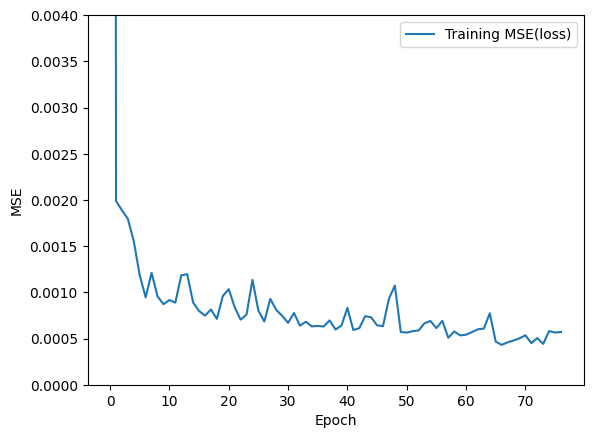

In [ ]:
import matplotlib.pyplot as plt
MSE = litecoin_hist.history['loss']
MAE = litecoin_hist.history['MAE_price']
# Plot MSE
plt.plot(MSE, label='Training MSE(loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim((0,0.004))
plt.legend()
plt.show()

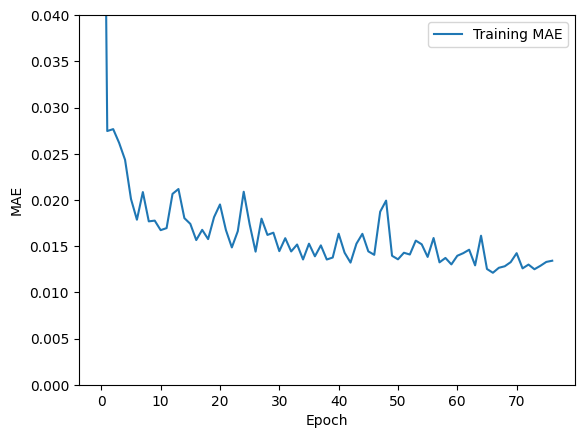

In [ ]:
plt.plot(MAE, label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim((0,0.04))
plt.legend()
plt.show()

In [ ]:
#one day window(predict 23 of February 2020)
litecoin_pred=predict_next_days('drive/MyDrive/litecoin.hdf5',litecoin_test[6:36],window_length=1)
litecoin_pred=np.squeeze(np.array(litecoin_pred))
price_pred=litecoin_pred[0]
real_price=litecoin_test.Price.iloc[-1]
#print(f'real_price={real_price},predicted_price={price_pred}')
pred_df = litecoin_scaler.inverse_transform(litecoin_pred.reshape(1,-1))
# Extract only the first column as it contains the inverse transformed values for price predictions.
prediction = np.array(pred_df[:, 0])
target_df=litecoin_scaler.inverse_transform(litecoin_test[-1:])
target=np.array(target_df[:,0])

1/1 [==============================] - 1s 1s/step


In [ ]:
proposed_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
proposed_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
proposed_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
proposed_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for one day window(litecoin):MSE={proposed_monero_MSE},MAE={proposed_monero_MAE},MAPE={proposed_monero_MAPE},RMSE={proposed_monero_RMSE}')

for one day window(litecoin):MSE=11.40845012664795,MAE=3.3776397705078125,MAPE=4.2376227378845215,RMSE=3.3776397705078125


In [ ]:
#three day window(predict from21 to 23February)
litecoin_pred=predict_next_days('drive/MyDrive/litecoin.hdf5',litecoin_test[4:34],window_length=3)
litecoin_pred=np.squeeze(np.array(litecoin_pred))
pred_df=litecoin_scaler.inverse_transform(litecoin_pred)
prediction = np.array(pred_df[:, 0])
target_df=litecoin_scaler.inverse_transform(litecoin_test[-3:])
target=np.array(target_df[:,0])

1/1 [==============================] - 2s 2s/step


In [ ]:
proposed_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
proposed_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
proposed_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
proposed_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for three day window(litecoin):MSE={proposed_monero_MSE},MAE={proposed_monero_MAE},MAPE={proposed_monero_MAPE},RMSE={proposed_monero_RMSE}')

for three day window(litecoin):MSE=17.672876358032227,MAE=2.8093643188476562,MAPE=3.563589334487915,RMSE=4.203912258148193


In [ ]:
#seven day window(predict from17 to 23 february)
litecoin_pred=predict_next_days('drive/MyDrive/litecoin.hdf5',litecoin_test[0:30],window_length=7)
litecoin_pred=np.squeeze(np.array(litecoin_pred))
pred_df=litecoin_scaler.inverse_transform(litecoin_pred)
prediction = np.array(pred_df[:, 0])
target_df=litecoin_scaler.inverse_transform(litecoin_test[-7:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 33ms/step


In [ ]:
proposed_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
proposed_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
proposed_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
proposed_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for seven day window(litecoin):MSE={proposed_monero_MSE},MAE={proposed_monero_MAE},MAPE={proposed_monero_MAPE},RMSE={proposed_monero_RMSE}')

for seven day window(litecoin):MSE=48.334190368652344,MAE=5.896095275878906,MAPE=7.893928050994873,RMSE=6.952279567718506


#LSTM model monero

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,LSTM,Input
LSTM_Model=Sequential()
LSTM_Model.add(LSTM(50,input_shape=(30,6)))
LSTM_Model.add(Dense(6,activation=relu))
LSTM_Model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 50)                11400     
                                                                 
 dense_6 (Dense)             (None, 6)                 306       
                                                                 
Total params: 11,706
Trainable params: 11,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_Model.compile(optimizer=Adam(learning_rate=0.001),loss=MSE_price,metrics=[MAE_price,MAPE_price,RMSE_price])
#lr_schedule=tf.keras.callbacks.LearningRateScheduler(litecoin_scheduler)                                                                                            
monero_LSTM_cp = ModelCheckpoint('drive/MyDrive/monero_lstm.hdf5', monitor='MAE_price', mode='min')
earlystopping= EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
monero_lstm_hist=LSTM_Model.fit(monero_x,monero_y,batch_size=32,epochs=100,callbacks=[monero_LSTM_cp])

Epoch 1/100
57/57 [==============================] - 4s 7ms/step - loss: 0.0033 - MAE_price: 0.0291 - MAPE_price: 355.7423 - RMSE_price: 0.0445
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 7.1706e-04 - MAE_price: 0.0124 - MAPE_price: 39.6092 - RMSE_price: 0.0248
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 6.6457e-04 - MAE_price: 0.0122 - MAPE_price: 70.5794 - RMSE_price: 0.0240
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 5.9542e-04 - MAE_price: 0.0117 - MAPE_price: 63.1386 - RMSE_price: 0.0227
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 5.3499e-04 - MAE_price: 0.0111 - MAPE_price: 68.7933 - RMSE_price: 0.0212
Epoch 6/100
57/57 [==============================] - 0s 7ms/step - loss: 4.9235e-04 - MAE_price: 0.0102 - MAPE_price: 40.1952 - RMSE_price: 0.0202
Epoch 7/100
57/57 [==============================] - 0s 5ms/step - loss: 4.8093e-04 - MAE_price: 0.0102 - MAPE_price: 50.

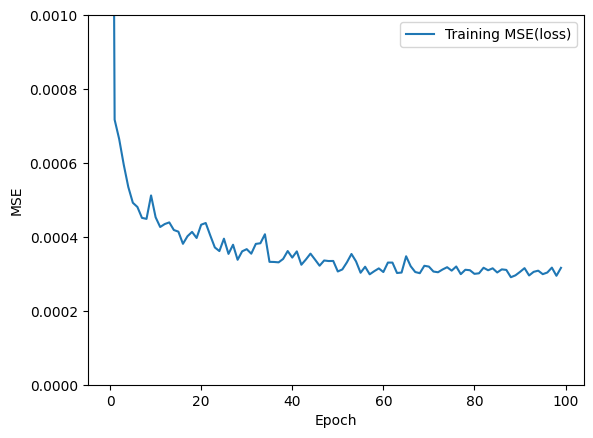

In [ ]:
import matplotlib.pyplot as plt
MSE = monero_lstm_hist.history['loss']
MAE = monero_lstm_hist.history['MAE_price']
plt.plot(MSE, label='Training MSE(loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim((0,0.001))
plt.legend()
plt.show()

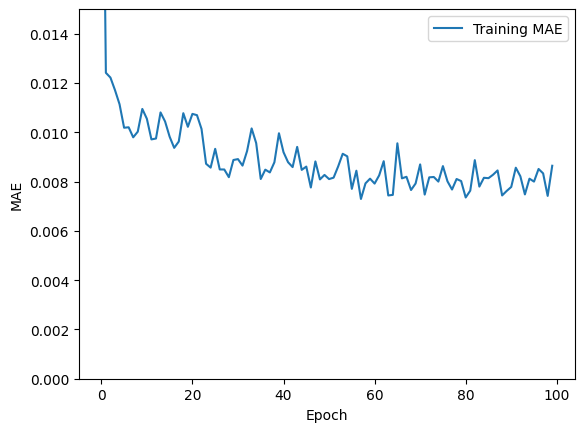

In [ ]:
plt.plot(MAE, label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim((0,0.015))
plt.legend()
plt.show()

In [ ]:
def predict_next_days_LSTM(weights_path,monero_test_input,window_length=7):
  LSTM_Model.load_weights(weights_path)
  monero_test_input=np.array(monero_test_input)
  predicted_days=[]
  for i in range(window_length):
    if i!=0:
      monero_test_input=np.append(monero_test_input[i:],day,axis=0)
    day=LSTM_Model.predict(tf.expand_dims(monero_test_input,axis=0))
    predicted_days.append(day)
  return predicted_days

In [ ]:
#one day window(predict 23 of February 2020)
monero_pred=predict_next_days_LSTM('drive/MyDrive/monero_lstm.hdf5',monero_test[6:36],window_length=1)
monero_pred=np.squeeze(np.array(monero_pred))
price_pred=monero_pred[0]
real_price=monero_test.Price.iloc[-1]
#print(f'real_price={real_price},predicted_price={price_pred}')
pred_df = monero_scaler.inverse_transform(monero_pred.reshape(1,-1))
# Extract only the first column as it contains the inverse transformed values for price predictions.
prediction = np.array(pred_df[:, 0])
target_df=monero_scaler.inverse_transform(monero_test[-1:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 367ms/step


In [ ]:
lstm_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
lstm_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
lstm_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
lstm_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for one day window(monero):MSE={lstm_monero_MSE},MAE={lstm_monero_MAE},MAPE={lstm_monero_MAPE},RMSE={lstm_monero_RMSE}')

for one day window(monero):MSE=55.70350646972656,MAE=7.463478088378906,MAPE=8.746707916259766,RMSE=7.463478088378906


In [ ]:
#three day window(predict from21 to 23February)
monero_pred=predict_next_days_LSTM('drive/MyDrive/monero_lstm.hdf5',monero_test[4:34],window_length=3)
monero_pred=np.squeeze(np.array(monero_pred))
pred_df=monero_scaler.inverse_transform(monero_pred)
prediction = np.array(pred_df[:, 0])
target_df=monero_scaler.inverse_transform(monero_test[-3:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 329ms/step


In [ ]:
lstm_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
lstm_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
lstm_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
lstm_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for three day window(monero):MSE={lstm_monero_MSE},MAE={lstm_monero_MAE},MAPE={lstm_monero_MAPE},RMSE={lstm_monero_RMSE}')

for three day window(monero):MSE=222.58734130859375,MAE=13.118376731872559,MAPE=15.88123607635498,RMSE=14.919361114501953


In [ ]:
#seven day window(predict from17 to 23 february)
monero_pred=predict_next_days_LSTM('drive/MyDrive/monero_lstm.hdf5',monero_test[0:30],window_length=7)
monero_pred=np.squeeze(np.array(monero_pred))
pred_df=monero_scaler.inverse_transform(monero_pred)
prediction = np.array(pred_df[:, 0])
target_df=monero_scaler.inverse_transform(monero_test[-7:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 36ms/step


In [ ]:
lstm_monero_MSE=tf.metrics.MeanSquaredError()(target,prediction)
lstm_monero_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
lstm_monero_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
lstm_monero_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for seven day window(monero):MSE={lstm_monero_MSE},MAE={lstm_monero_MAE},MAPE={lstm_monero_MAPE},RMSE={lstm_monero_RMSE}')

for seven day window(monero):MSE=270.1586608886719,MAE=15.190495491027832,MAPE=18.69815444946289,RMSE=16.436504364013672


#LSTM Model litecoin

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,LSTM,Input
LSTM_Model=Sequential()
LSTM_Model.add(LSTM(50,input_shape=(30,6)))
LSTM_Model.add(Dense(6,activation=relu))
LSTM_Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                11400     
                                                                 
 dense_7 (Dense)             (None, 6)                 306       
                                                                 
Total params: 11,706
Trainable params: 11,706
Non-trainable params: 0
_________________________________________________________________


In [ ]:
LSTM_Model.compile(optimizer=Adam(learning_rate=0.001),loss=MSE_price,metrics=[MAE_price,MAPE_price,RMSE_price])
#lr_schedule=tf.keras.callbacks.LearningRateScheduler(litecoin_scheduler)                                                                                            
litecoin_LSTM_cp = ModelCheckpoint('drive/MyDrive/litecoin_lstm.hdf5', monitor='MAE_price', mode='min')
#earlystopping= EarlyStopping(monitor='loss', patience=10, verbose=0, mode='min')
litecoin_lstm_hist=LSTM_Model.fit(monero_x,monero_y,batch_size=32,epochs=100,callbacks=[litecoin_LSTM_cp])

Epoch 1/100
57/57 [==============================] - 3s 11ms/step - loss: 0.0071 - MAE_price: 0.0444 - MAPE_price: 604.1456 - RMSE_price: 0.0666
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 7.9489e-04 - MAE_price: 0.0138 - MAPE_price: 73.0869 - RMSE_price: 0.0261
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 6.7758e-04 - MAE_price: 0.0124 - MAPE_price: 45.0611 - RMSE_price: 0.0241
Epoch 4/100
57/57 [==============================] - 0s 6ms/step - loss: 6.1699e-04 - MAE_price: 0.0126 - MAPE_price: 45.2746 - RMSE_price: 0.0234
Epoch 5/100
57/57 [==============================] - 0s 6ms/step - loss: 5.9181e-04 - MAE_price: 0.0126 - MAPE_price: 66.7972 - RMSE_price: 0.0230
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 6.4106e-04 - MAE_price: 0.0127 - MAPE_price: 64.2023 - RMSE_price: 0.0235
Epoch 7/100
57/57 [==============================] - 0s 6ms/step - loss: 5.2117e-04 - MAE_price: 0.0109 - MAPE_price: 56

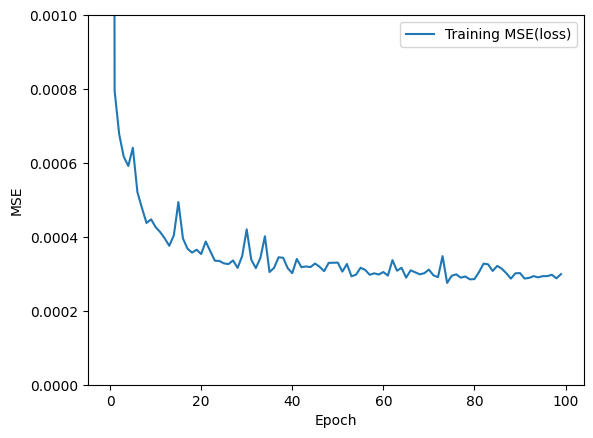

In [ ]:
import matplotlib.pyplot as plt
MSE = litecoin_lstm_hist.history['loss']
MAE = litecoin_lstm_hist.history['MAE_price']
plt.plot(MSE, label='Training MSE(loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim((0,0.001))
plt.legend()
plt.show()

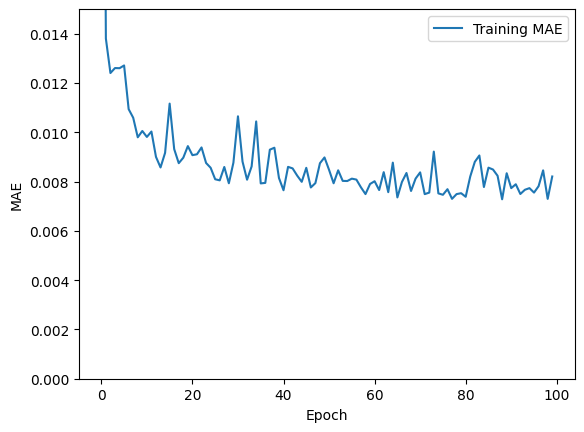

In [ ]:
plt.plot(MAE, label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim((0,0.015))
plt.legend()
plt.show()

In [ ]:
#one day window(predict 23 of February 2020)
litecoin_pred=predict_next_days_LSTM('drive/MyDrive/litecoin_lstm.hdf5',litecoin_test[6:36],window_length=1)
litecoin_pred=np.squeeze(np.array(litecoin_pred))
price_pred=litecoin_pred[0]
real_price=litecoin_test.Price.iloc[-1]
#print(f'real_price={real_price},predicted_price={price_pred}')
pred_df = litecoin_scaler.inverse_transform(litecoin_pred.reshape(1,-1))
# Extract only the first column as it contains the inverse transformed values for price predictions.
prediction = np.array(pred_df[:, 0])
target_df=litecoin_scaler.inverse_transform(litecoin_test[-1:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 48ms/step


In [ ]:
lstm_litecoin_MSE=tf.metrics.MeanSquaredError()(target,prediction)
lstm_litecoin_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
lstm_litecoin_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
lstm_litecoin_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for one day window(litecoin):MSE={lstm_litecoin_MSE},MAE={lstm_litecoin_MAE},MAPE={lstm_litecoin_MAPE},RMSE={lstm_litecoin_RMSE}')

for one day window(litecoin):MSE=29.24445343017578,MAE=5.407814025878906,MAPE=6.784701347351074,RMSE=5.407814025878906


In [ ]:
#three day window(predict from21 to 23February)
litecoin_pred=predict_next_days_LSTM('drive/MyDrive/litecoin_lstm.hdf5',litecoin_test[4:34],window_length=3)
litecoin_pred=np.squeeze(np.array(litecoin_pred))
pred_df=litecoin_scaler.inverse_transform(litecoin_pred)
prediction = np.array(pred_df[:, 0])
target_df=litecoin_scaler.inverse_transform(litecoin_test[-3:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 19ms/step


In [ ]:
lstm_litecoin_MSE=tf.metrics.MeanSquaredError()(target,prediction)
lstm_litecoin_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
lstm_litecoin_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
lstm_litecoin_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for three day window(litecoin):MSE={lstm_litecoin_MSE},MAE={lstm_litecoin_MAE},MAPE={lstm_litecoin_MAPE},RMSE={lstm_litecoin_RMSE}')

for three day window(litecoin):MSE=240.53062438964844,MAE=13.629310607910156,MAPE=17.64239501953125,RMSE=15.509049415588379


In [ ]:
#seven day window(predict from21 to 23February)
litecoin_pred=predict_next_days_LSTM('drive/MyDrive/litecoin_lstm.hdf5',litecoin_test[0:30],window_length=7)
litecoin_pred=np.squeeze(np.array(litecoin_pred))
pred_df=litecoin_scaler.inverse_transform(litecoin_pred)
prediction = np.array(pred_df[:, 0])
target_df=litecoin_scaler.inverse_transform(litecoin_test[-7:])
target=np.array(target_df[:,0])

1/1 [==============================] - 0s 36ms/step


In [ ]:
lstm_litecoin_MSE=tf.metrics.MeanSquaredError()(target,prediction)
lstm_litecoin_MAE=tf.metrics.MeanAbsoluteError()(target,prediction)
lstm_litecoin_RMSE=tf.metrics.RootMeanSquaredError()(target,prediction)
lstm_litecoin_MAPE=tf.metrics.MeanAbsolutePercentageError()(target,prediction)
print(f'for seven day window(litecoin):MSE={lstm_litecoin_MSE},MAE={lstm_litecoin_MAE},MAPE={lstm_litecoin_MAPE},RMSE={lstm_litecoin_RMSE}')

for seven day window(litecoin):MSE=284.1758728027344,MAE=15.028607368469238,MAPE=20.090362548828125,RMSE=16.85751724243164
